# 트랜스포머를 사용한 비디오 분류

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/06/08<br>
**Last modified:** 2021/06/08<br>
**Description:** 하이브리드 트랜스포머로 비디오 분류기 훈련.

이 예는
[CNN-RNN 아키텍처를 통한 비디오 분류](https://keras.io/examples/vision/video_classification/)
예시. 이번에는 Transformer 기반 모델을 사용할 것입니다.
([Vaswani et al.](https://arxiv.org/abs/1706.03762)) 비디오를 분류합니다. 당신은 따라갈 수 있습니다
[이 책 챕터](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11)
Transformers(코드 포함)에 대한 소개가 필요한 경우.
이 예제를 읽고 나면 CNN 기능 맵에서 작동하는 비디오 분류를 위한 하이브리드 변환기 기반 모델을 개발하는 방법을 알게 될 것입니다.

이 예제에는 TensorFlow 2.5 이상이 필요하며 다음 명령을 사용하여 설치할 수 있는 TensorFlow Docs가 필요합니다.

In [52]:
!pip install -q git+https://github.com/tensorflow/docs

## 데이터 수집

[전임자](https://keras.io/examples/vision/video_classification/)에서 수행한 대로
이 예에서는 서브샘플링된 버전의
[UCF101 데이터세트](https://www.crcv.ucf.edu/data/UCF101.php),
잘 알려진 벤치마크 데이터 세트. 더 큰 하위 샘플 또는 전체 데이터 세트에서 작업하려는 경우 다음을 참조하십시오.
[이 노트](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb).

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## 설정

In [53]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## 하이퍼파라미터 정의

In [54]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

## 데이터 준비

다음 변경 사항을 제외하고 대부분 이 예에서 동일한 데이터 준비 단계를 따릅니다.

* 연산 속도를 높이기 위해 이미지 크기를 224x224 대신 128x128로 줄였습니다.
* 사전 훈련된 [InceptionV3](https://arxiv.org/abs/1512.00567) 네트워크를 사용하는 대신,
사전 훈련된 [DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)을 사용합니다.
특징 추출을 위해
* 짧은 동영상을 'MAX_SEQ_LENGTH' 길이로 직접 채웁니다.

먼저 [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)를 로드합니다.

In [55]:
train_df = pd.read_csv("./ucf101_top5/train.csv")
test_df = pd.read_csv("./ucf101_top5/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total videos for training: 594
Total videos for testing: 224
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


`train_df` 및 `test_df`에서 `prepare_all_videos()`를 호출하면 완료하는 데 20분 정도 걸립니다. 이러한 이유로 시간을 절약하기 위해 여기에서 이미 사전 처리된 NumPy 배열을 다운로드합니다.

In [ ]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [56]:
train_data, train_labels = np.load("./ucf101_top5/train_data.npy"), np.load("./ucf101_top5/train_labels.npy")
test_data, test_labels = np.load("./ucf101_top5/test_data.npy"), np.load("./ucf101_top5/test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Transformer 기반 모델 구축

우리는 공유된 코드를 기반으로 구축할 것입니다.
[이 책 챕터](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11)
[파이썬을 이용한 딥러닝(2판)](https://www.manning.com/books/deep-learning-with-python)
프랑수아 숄레.

첫째, Transformer의 기본 블록을 구성하는 self-attention layer는 순서에 구애받지 않습니다. 비디오는 순서가 지정된 프레임 시퀀스이므로 순서 정보를 고려하려면 Transformer 모델이 필요합니다.
**위치 인코딩**을 통해 이 작업을 수행합니다.
[`Embedding` 레이어](https://keras.io/api/layers/core_layers/embedding)를 사용하여 동영상 내부에 있는 프레임의 위치를 포함하기만 하면 됩니다. 우리는 그때
이러한 위치 임베딩을 미리 계산된 CNN 기능 맵에 추가합니다.

In [58]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        print(length)
        positions = tf.range(start=0, limit=length, delta=1)
        print(positions)
        embedded_positions = self.position_embeddings(positions)
        print(embedded_positions.shape, inputs.shape)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        print(mask)
        return mask


### PositionalEmbedding Test

In [59]:
image = tf.constant(np.arange(3*4).reshape(1,3,4), dtype="float32")
pe = PositionalEmbedding(3,4)
pe(image)

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)
(3, 4) (1, 3, 4)
tf.Tensor([[ True  True  True]], shape=(1, 3), dtype=bool)


<tf.Tensor: shape=(1, 3, 4), dtype=float32, numpy=
array([[[-4.5810938e-03,  1.0442697e+00,  1.9540508e+00,  3.0193551e+00],
        [ 3.9839125e+00,  4.9524207e+00,  5.9888625e+00,  7.0046320e+00],
        [ 7.9742355e+00,  9.0419674e+00,  1.0010903e+01,  1.1024492e+01]]],
      dtype=float32)>

이제 Transformer에 대한 하위 클래스 레이어를 생성할 수 있습니다.

In [60]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        print(attention_output.shape)
        proj_input = self.layernorm_1(inputs + attention_output)
        print(proj_input.shape)
        proj_output = self.dense_proj(proj_input)
        print(proj_output.shape)
        return self.layernorm_2(proj_input + proj_output)


### TransformerEncoder Test

In [61]:
image = tf.constant(np.arange(3*4).reshape(1,3,4), dtype="float32")
te = TransformerEncoder(4,2,4)
te(image)

(1, 3, 4)
(1, 3, 4)
(1, 3, 4)


<tf.Tensor: shape=(1, 3, 4), dtype=float32, numpy=
array([[[-0.8875538 , -0.14582022,  1.6685543 , -0.63518023],
        [-0.8944133 , -0.20611781,  1.6790841 , -0.5785529 ],
        [-0.9069432 , -0.2611715 ,  1.6848474 , -0.51673263]]],
      dtype=float32)>

## 훈련을 위한 함수

In [68]:

def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)    # (1,20,1024)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)  # (1,20,1024)
    x = layers.GlobalMaxPooling1D()(x)   # (1,1024)
    x = layers.Dropout(0.5)(x)           # (1,1024)
    outputs = layers.Dense(classes, activation="softmax")(x)  # (1,1024)(1024,5) => (1,5)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model


## 모델 훈련 및 추론

In [69]:
trained_model = run_experiment()

Tensor("frame_position_embedding/strided_slice:0", shape=(), dtype=int32)
Tensor("frame_position_embedding/range:0", shape=(None,), dtype=int32)
(None, 1024) (None, None, None)
Tensor("Any:0", shape=(None, None), dtype=bool)
(None, None, 1024)
(None, None, 1024)
(None, None, 1024)
Epoch 1/5
Tensor("model_2/frame_position_embedding/strided_slice:0", shape=(), dtype=int32)
Tensor("model_2/frame_position_embedding/range:0", shape=(20,), dtype=int32)
(20, 1024) (None, 20, 1024)
Tensor("model_2/frame_position_embedding/Any:0", shape=(None, 20), dtype=bool)
(None, 20, 1024)
(None, 20, 1024)
(None, 20, 1024)
Tensor("model_2/frame_position_embedding/strided_slice:0", shape=(), dtype=int32)
Tensor("model_2/frame_position_embedding/range:0", shape=(20,), dtype=int32)
(20, 1024) (None, 20, 1024)
Tensor("model_2/frame_position_embedding/Any:0", shape=(None, 20), dtype=bool)
(None, 20, 1024)
(None, 20, 1024)
(None, 20, 1024)
16/16 [==============================] - ETA: 0s - loss: 1.0700 - accuracy

**참고**: 이 모델에는 ~423만 개의 매개변수가 있으며 이는 이 예제의 전편에서 사용한 시퀀스 모델(99918개 매개변수)보다 훨씬 많습니다. 이러한 종류의 Transformer 모델은 더 큰 데이터 세트와 더 긴 사전 교육 일정에서 가장 잘 작동합니다.

Test video path: ./ucf101_top5/test/v_CricketShot_g05_c03.avi
  CricketShot: 99.81%
  TennisSwing:  0.19%
  Punch:  0.00%
  ShavingBeard:  0.00%
  PlayingCello:  0.00%



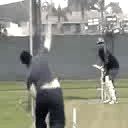

In [77]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(path)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
test_video = "./ucf101_top5/test/"+test_video
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

우리 모델의 성능은 작은 데이터 세트에서 훈련되었기 때문에 최적과는 거리가 멉니다.